# ML ШИФТ

# Содержание

- [1 Описание задачи](#1-описание-задачи)
- [2 Импорт библиотек](#2-импорт-библиотек)
- [3 Первичный анализ и предобработка данных](#3-первичный-анализ-и-предобработка-данных)
- [4 Генерирование признаков](#4-генерирование-признаков)
- [5 Анализ данных](#5-анализ-данных)
  - [5.1 Повторное срабатывание турникетов](#5.1-повторное-срабатывание-турникетов)
  - [5.2 Количество проходов через турникеты в неделю](#5.2-количество-проходов-через-турникеты-в-неделю)
  - [5.3 Phik корреляция признаков с целевым признаком](#5.3-phik-корреляция-признаков-с-целевым-признаком)
- [6 Построение моделей](#6-построение-моделей)
  - [6.1 Подготовка данных](#6.1-подготовка-данных)
  - [6.2 Подбор гиперпараметров](#6.2-подбор-гиперпараметров)
  - [6.3 Отбор признаков](#6.3-отбор-признаков)
  - [6.4 Подбор гиперпараметров после отбора признаков](#6.4-подбор-гиперпараметров-после-отбора-признаков)
  - [6.5 Итоговое предсказание лучшей модели](#6.5-итоговое-предсказание-лучшей-модели)


# 1 Описание задачи


Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# 2 Импорт библиотек


In [1]:
import io
import warnings
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import phik
import plotly.graph_objects as go
import seaborn as sns
import sklearn

from catboost import (CatBoostClassifier,
                      EFeaturesSelectionAlgorithm,
                      EShapCalcType,
                      Pool)
from scipy.stats import mode
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

RANDOM_STATE = 42

# 3 Первичный анализ и предобработка данных


In [3]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [4]:
for name, df in zip(['Тренировочная выборка', 'Тестовая выборка', 'Пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    if name != 'Пример решения':
        print(f'\033[1mОбщая информация - {name}:\033[0m')
        df.info()
        print(f'\033[1mКоличество пропусков: {df.isna().sum().sum()}\033[0m')
        print(f'\033[1mКоличество явных дубликатов: {df.duplicated().sum()}\033[0m')
        print()

Тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


Общая информация - Тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
Количество пропусков: 0
Количество явных дубликатов: 2346

Тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


Общая информация - Тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
Количество пропусков: 0
Количество явных дубликатов: 505

Пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [5]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [6]:
df_train.shape

(35172, 3)

In [7]:
df_test.shape

(6620, 3)

In [8]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [9]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [10]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников в тренировочной выборке

In [11]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {df_train.user_id.nunique()}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [12]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [13]:
# активность сотрудников в train
count_user_id = pd.concat([df_train.user_id.value_counts(), df_train.user_id.value_counts(normalize=True)*100], axis=1)
count_user_id.columns = ['Абсолютная частота', 'Проценты']
count_user_id.astype('object').T

user_id,37,55,6,12,19,15,18,53,11,47,33,0,1,49,39,32,9,54,50,29,3,48,17,14,35,27,57,46,24,42,26,34,23,40,25,31,56,43,20,41,22,28,45,7,36,2,8,10,38,5,30,52,21,44,51,4
Абсолютная частота,2184,2166,1857,1837,1661,1659,1441,1279,1255,1250,1184,1184,1171,1129,1032,1020,1015,977,965,924,894,712,648,617,549,523,482,475,386,340,279,267,247,242,238,181,129,117,112,110,87,64,57,48,45,39,27,17,13,10,10,5,5,4,2,1
Проценты,6.21,6.16,5.28,5.22,4.72,4.72,4.10,3.64,3.57,3.55,3.37,3.37,3.33,3.21,2.93,2.90,2.89,2.78,2.74,2.63,2.54,2.02,1.84,1.75,1.56,1.49,1.37,1.35,1.10,0.97,0.79,0.76,0.70,0.69,0.68,0.51,0.37,0.33,0.32,0.31,0.25,0.18,0.16,0.14,0.13,0.11,0.08,0.05,0.04,0.03,0.03,0.01,0.01,0.01,0.01,0.00


ID сотрудников в тестовой выборке

In [14]:
print(*sorted(df_test.user_word.unique()), sep=', ')
print(f'Количество сотрудников в test: {df_test.user_word.nunique()}')

aucroc, binary, blue, categorical, coefficient, collinear, distributed, epsilon, f1, fit, gini, independent, lasso, linear, logistic, loss, matrix, minimization, mse, ols, precision, predict, pvalue, r2, recall, regression, residual, ridge, sigmoid, significant, target, tstat, x, y
Количество сотрудников в test: 34


In [15]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * df_test.user_word.nunique())

3

In [16]:
# активность сотрудников в test
count_user_word = pd.concat([df_test.user_word.value_counts(), df_test.user_word.value_counts(normalize=True)*100], axis=1)
count_user_word.columns = ['Абсолютная частота', 'Проценты']
count_user_word.astype('object').T

user_word,f1,loss,sigmoid,binary,epsilon,collinear,x,independent,significant,gini,categorical,residual,recall,predict,linear,r2,fit,pvalue,matrix,ridge,ols,tstat,distributed,target,mse,minimization,coefficient,precision,regression,y,aucroc,lasso,blue,logistic
Абсолютная частота,694,458,432,362,336,298,298,278,277,253,245,224,210,208,199,185,183,181,157,141,139,139,117,111,103,95,56,54,50,50,37,33,12,5
Проценты,10.48,6.92,6.53,5.47,5.08,4.50,4.50,4.20,4.18,3.82,3.70,3.38,3.17,3.14,3.01,2.79,2.76,2.73,2.37,2.13,2.10,2.10,1.77,1.68,1.56,1.44,0.85,0.82,0.76,0.76,0.56,0.50,0.18,0.08


Рассмотрим распределение количества пересечений турникетов по дням каждым сотрудником из обеих выборок

In [17]:
df_train['date'] = df_train.ts.dt.date
df_test['date'] = df_test.ts.dt.date

# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

In [18]:
def plot_pass_count(df, save_path):
    pivot_df = pd.pivot_table(
        df,
        index='date',
        columns='user_id',
        values='gate_id',
        aggfunc='count',
        fill_value=0
    )
    fig = go.Figure()

    users = pivot_df.columns
    for user in users:
        fig.add_trace(go.Bar(
            x=pivot_df.index,
            y=pivot_df[user],
            name=f'user_id = {user}',
            marker_color='purple',
            visible=False   # все графики невидимы изначально
        ))

    # показываем первый график по умолчанию
    fig.data[0].visible = True

    # создание выпадающего списка для переключения между посетителями
    dropdown_buttons = [
        dict(
            label=f'Сотрудник {user}',
            method='update',
            args=[{'visible': [u == user for u in users]},
                {'title': f'Количество пересечений турникетов сотрудником {user}'}]
        ) for user in users
    ]

    # добавление выпадающего списка в макет графика
    fig.update_layout(
        updatemenus=[
            dict(
                active=0,
                buttons=dropdown_buttons,
                x=0.1,
                xanchor='left',
                y=1.15,
                yanchor='top'
            )
        ],
        title=f'Количество пересечений турникетов сотрудником {users[0]}',
        xaxis_title='Дата',
        yaxis_title='Количество проходов',
        showlegend=False,
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            linecolor='darkgray',
            linewidth=1,
            tickformat='%d.%m.%y',
            dtick='M1',
        ),
        yaxis=dict(
            linecolor='darkgray',
            linewidth=1,
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=.5
        )
    )

    fig.write_html(save_path)
    fig.show()

In [19]:
# на выпадающем списке id сотрудников есть серый ползунок справа для перемещения по списку 
# (еще можно с зажатой левой кнопкой мыши перемещаться)
plot_pass_count(df_train, '../pictures/pass_counts_train.html')

In [20]:
plot_pass_count(df_test, '../pictures/pass_counts_test.html')

Удалим из обучающей выборки слишком маленькие категории сотрудников. Также исключим некоторых сотрудников из тренировочной выборки, исходя из графиков посещений здания для каждого сотрудника. Их выбор основан на резком изменеии поведения, большим временным промежутком, в течение которого они не посещают здание.

* 4, 51, 44, 21, 52, 30, 5, 38, 10, 8 - мало записей
* 7 - последний раз был в здании 24 октября
* 18 - прекратил свое стандартное поведение 26 октября
* 20 - последний раз был в здании 17 августа
* 27 - с августа по середину сентября выходил пять дней в неделю, затем - пререрыв, 7 раз был в октябре, 1 раз - в конце ноября
* 28 - последнее появление 20 октября
* 31 - изменение поведения, последний раз был 17 октября (только один проход)
* 40 - последнее появление 14 октября
* 42 - последний раз был в здании 17 октября
* 45 - последнее появление 21 октября
* 47 - последняя полноценная активность - 11 ноября, 23 декабря - один проход через турникет
* 48 - ситуация как с 47
* 53 - ситуация как с 47
* 57 - резкое изменение поведения 7 октября, затем всего 2 появления в здании

In [21]:
delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 27, 28, 30, 31, 34, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]
len(delete_user_id)

25

In [22]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(27970, 4)

In [23]:
print(f'Количество сотрудников в train: {df_train.user_id.nunique()}')

Количество сотрудников в train: 31


Турникеты

In [24]:
print(f'Количество турникетов в train: {df_train.gate_id.nunique()}')
# частота использования турникетов в train
count_gate_id_train = pd.concat([df_train.gate_id.value_counts(), df_train.gate_id.value_counts(normalize=True)*100], axis=1)
count_gate_id_train.columns = ['Абсолютная_частота', 'Проценты']
count_gate_id_train.astype('object').T

Количество турникетов в train: 17


gate_id,4,3,10,5,11,7,9,6,13,12,15,-1,8,1,16,0,14
Абсолютная_частота,6380,4013,3905,3716,3356,2406,1440,1309,720,378,298,23,15,5,3,2,1
Проценты,22.81,14.35,13.96,13.29,12.00,8.60,5.15,4.68,2.57,1.35,1.07,0.08,0.05,0.02,0.01,0.01,0.00


In [25]:
print(f'Количество турникетов в test: {df_test.gate_id.nunique()}')
# частота использования турникетов в test
count_gate_id_test = pd.concat([df_test.gate_id.value_counts(), df_test.gate_id.value_counts(normalize=True)*100], axis=1)
count_gate_id_test.columns = ['Абсолютная_частота', 'Проценты']
count_gate_id_test.astype('object').T

Количество турникетов в test: 16


gate_id,4,10,3,5,11,7,9,13,6,12,15,8,2,1,14,-1
Абсолютная_частота,1431,915,893,853,762,540,394,310,282,120,102,10,4,2,1,1
Проценты,21.62,13.82,13.49,12.89,11.51,8.16,5.95,4.68,4.26,1.81,1.54,0.15,0.06,0.03,0.02,0.02


In [26]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [27]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [28]:
delete_gate_id = set(count_gate_id_train.query('Абсолютная_частота < 5').index) | set(count_gate_id_test.query('Абсолютная_частота < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [29]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [30]:
df_test.shape

(6612, 4)

# 4 Генерирование признаков


In [31]:
def calculate_time_features(df):
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week
    df['day_of_week'] = df.ts.dt.dayofweek
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
        condlist=[df.hour < 6, df.hour < 12, df.hour < 18],
        choicelist=['night', 'morning', 'afternoon'],
        default='evening'
    )
    df['is_month_start'] = df.ts.dt.is_month_start
    df['is_month_end'] = df.ts.dt.is_month_end
    return df

def calculate_pass_counts(df):
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')
    return df

def calculate_time_at_work(df):
    grouped_data = df.groupby(['user_id', 'date'])
    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)
    return df

def calculate_gate_lags(df):
    grouped_data = df.groupby(['user_id', 'date'])
    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')
    return df

def calculate_repeated_gates(df):
    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1, 2, 3, 4 секундам соответсвенно
    for sec in [1, 2, 3, 4]:
        df[f'repeat_gate_{sec}s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(sec)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями 1, 2, 3, 4 секунды и от 5 секунд
    for sec in [1, 2, 3, 4, 'ge_5']:
        df[f'cnt_repeat_gate_{sec}s'] = grouped_data[f'repeat_gate_{sec}s'].transform('sum')
    return df

def calculate_routes(df):
    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'
    
    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1'].clip(lower=0)
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())
    
    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    return df

def create_features(df):
    """Основная функция для генерации всех признаков."""
    df = df.copy()
    # отсортируем датафрейм для удобства генерирования признаков
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    df = calculate_time_features(df)
    df = calculate_pass_counts(df)
    df = calculate_time_at_work(df)
    df = calculate_gate_lags(df)
    df = calculate_repeated_gates(df)
    df = calculate_routes(df)
    return df

In [32]:
df_train = create_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,0,2022-07-29 10:30:17,3,2022-07-29,29,10,630,37817,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,-100,3,-1000,-1,-100,11,-1000,-10144,-100,6,-1000,-10171,-100,6,-1000,-10172,-100,7,-1000,-13798,False,False,False,False,False,2,2,0,0,0,not_route,0,0,0,3,3,"[3, 3]","[3, 3]",0.00,0.00
1,0,2022-07-29 10:30:18,3,2022-07-29,29,10,630,37818,30,4,False,morning,False,False,12,4,0.33,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,11,1,-10143,-100,6,-1000,-10170,-100,6,-1000,-10171,-100,7,-1000,-13797,-100,3,-1000,-13868,True,False,False,False,False,2,2,0,0,0,"[3, 3]",1,1,1,3,3,"[3, 3]","[3, 3]",1.50,1.92
2,0,2022-07-29 13:19:21,11,2022-07-29,29,13,799,47961,30,4,False,afternoon,False,False,12,2,0.17,17,17,1.00,1,630,1126,496,3,4,496,1.00,3,6,10143,-27,3,6,10144,-28,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,3,-1000,-3727,False,False,False,False,False,2,2,0,0,0,"[3, 11]",10143,10144,10143,3,3,"[3, 3]","[3, 3]","10,143.00","12,404.29"


In [33]:
df_train.shape

(27936, 68)

In [34]:
df_test = create_features(df_test)
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,weekly_route_avg_time,route_avg_time
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,4,11,667,40020,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,-100,9,-1000,-164,-100,5,-1000,-174,-100,5,-1000,-175,-100,10,-1000,-192,-100,11,-1000,-25885,False,False,False,False,False,1,1,0,0,0,not_route,0,0,0,15,5,not_route,not_route,0.00,0.00
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,4,11,669,40184,1,2,False,morning,False,False,9,1,0.11,21,27,0.78,2,667,1103,436,15,15,632,0.69,15,5,164,-10,-100,5,-1000,-11,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,False,False,False,False,False,1,1,0,0,0,"[9, 15]",164,164,164,15,5,not_route,not_route,164.00,211.33
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,4,11,669,40194,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,667,1103,436,15,15,632,0.69,9,5,10,-1,15,10,174,-18,-100,11,-1000,-25711,-100,4,-1000,-25736,-100,4,-1000,-25738,False,False,False,False,False,1,1,0,0,0,"[5, 9]",10,174,10,15,5,not_route,not_route,14.50,14.50


In [35]:
df_test.shape

(6612, 68)

In [36]:
df_train.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0)

# 5 Анализ данных


## 5.1 Повторное срабатывание турникетов


In [37]:
def plot_count_sec_btw_repeating_gate_id(df, max_interval_sec=50):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 < @max_interval_sec')
    plt.figure(figsize=(15, 3))
    sns.countplot(x='sec_btw_lag_1', data=df_repeating_gate_id, color='purple')
    plt.xlabel('Количество секунд между повторными срабатываниями турникетов')
    plt.ylabel('Количество повторных срабатываний')
    plt.title('Повторное срабатывание турникетов');

Рассмотрим тренировочную выборку

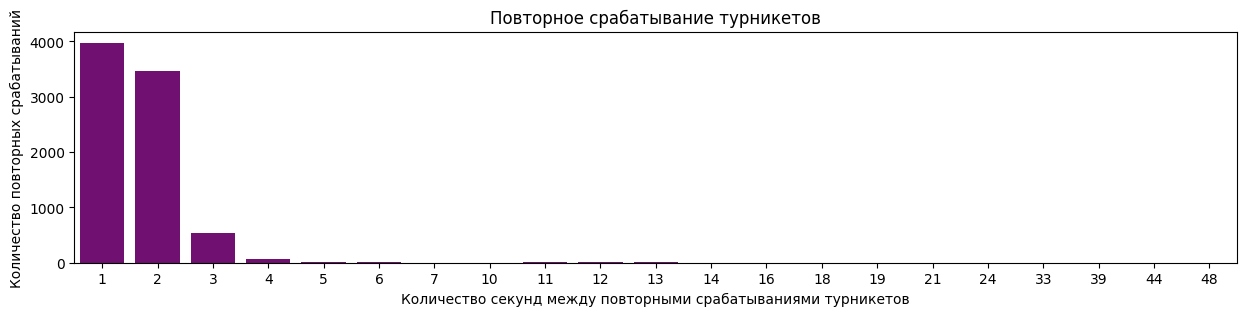

In [38]:
plot_count_sec_btw_repeating_gate_id(df_train)

In [39]:
df_train.query('gate_id == gate_id_lag_1')['gate_id'].value_counts().to_frame().T

gate_id,4,3,5,6,13,10,12,11,9,7,15
count,3116,1947,1834,631,349,324,168,56,33,17,16


In [40]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_train.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['gate_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


gate_id,4,3,5,6,13,12,9
count,1620,877,710,328,254,156,29


Количество секунд между срабатываниями = 2:


gate_id,4,5,3,6,13,12,7
count,1305,932,898,263,63,6,1


Количество секунд между срабатываниями = 3:


gate_id,5,4,3,6,13,7
count,169,162,152,38,5,1


Количество секунд между срабатываниями = 4:


gate_id,4,5,3,7,13
count,24,18,15,2,1


In [41]:
df_train.query('gate_id == gate_id_lag_1')['user_id'].value_counts().to_frame().T

user_id,37,55,6,12,19,15,11,0,33,1,39,50,49,54,32,29,9,3,17,46,14,35,24,25,26,23,56,43,22,36,2
count,815,687,657,552,515,488,453,353,332,306,295,295,288,273,272,266,252,241,185,168,167,149,104,84,75,74,52,37,27,16,13


In [42]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_train.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['user_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


user_id,19,6,55,37,15,11,33,12,32,1,49,54,9,29,0,50,17,3,39,46,25,35,24,26,23,56,43,2,36,22,14
count,429,340,336,329,253,239,203,195,191,188,168,146,131,109,107,102,98,92,71,59,37,35,29,25,22,13,10,5,4,4,4


Количество секунд между срабатываниями = 2:


user_id,55,37,12,15,0,6,11,39,50,29,3,33,54,9,49,1,35,17,46,32,19,14,24,26,23,25,56,43,22,36,2
count,291,278,264,217,204,178,176,163,160,133,132,123,119,115,110,106,88,83,81,80,67,63,47,45,40,34,28,17,10,9,7


Количество секунд между срабатываниями = 3:


user_id,14,12,39,0,37,55,50,35,46,24,29,6,3,22,23,15,25,43,1,56,11,49,19,54,33,36,17,9,26,32
count,75,52,45,37,34,33,28,21,21,20,19,17,16,12,11,10,10,9,9,8,8,7,5,5,4,3,3,2,2,1


Количество секунд между срабатываниями = 4:


user_id,14,39,12,37,50,35,46,0,6,11,15,22,23,24,25,29
count,18,11,7,4,4,3,3,2,1,1,1,1,1,1,1,1


Рассмотрим тестовую выборку

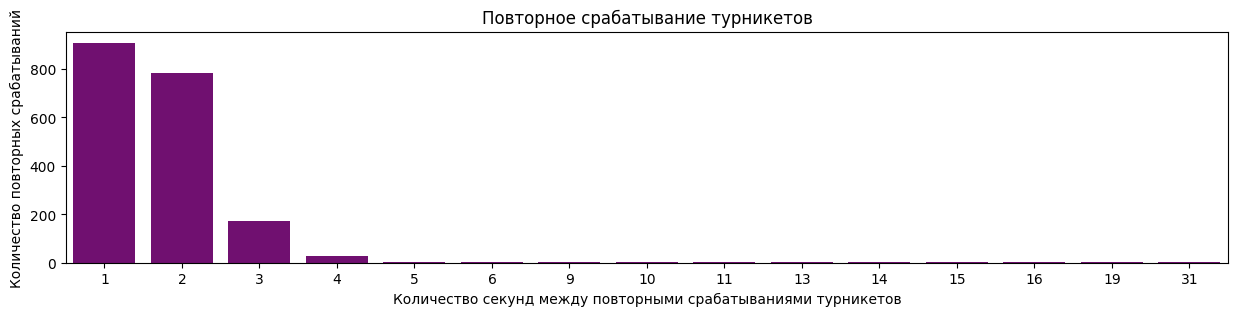

In [43]:
plot_count_sec_btw_repeating_gate_id(df_test)

In [44]:
df_test.query('gate_id == gate_id_lag_1')['gate_id'].value_counts().to_frame().T

gate_id,4,3,5,13,6,12,10,11,15,9,7,8
count,703,437,424,144,134,56,47,8,5,5,4,2


In [45]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_test.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['gate_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


gate_id,4,3,5,13,6,12,9,8
count,328,197,140,119,75,45,4,1


Количество секунд между срабатываниями = 2:


gate_id,4,3,5,6,13,12,7
count,315,198,190,53,17,9,1


Количество секунд между срабатываниями = 3:


gate_id,5,4,3,6,13
count,80,50,33,6,1


Количество секунд между срабатываниями = 4:


gate_id,5,4,3
count,11,9,6


In [46]:
df_test.query('gate_id == gate_id_lag_1')['user_id'].value_counts().to_frame().T

user_id,f1,loss,sigmoid,binary,x,epsilon,collinear,significant,independent,residual,predict,categorical,gini,linear,recall,fit,pvalue,r2,matrix,ols,target,tstat,ridge,distributed,mse,minimization,precision,coefficient,regression,y,lasso,aucroc,blue,logistic
count,230,142,120,109,108,93,85,78,72,68,67,66,63,57,57,52,52,49,46,46,42,41,40,37,30,29,18,16,14,13,13,9,5,2


In [47]:
for i in range(1, 5):
    print(f'Количество секунд между срабатываниями = {i}:')
    display(df_test.query('gate_id == gate_id_lag_1 and sec_btw_lag_1 == @i')['user_id'].value_counts().to_frame().T)

Количество секунд между срабатываниями = 1:


user_id,f1,loss,sigmoid,x,significant,epsilon,pvalue,gini,residual,linear,ols,tstat,binary,fit,r2,matrix,recall,collinear,predict,target,independent,distributed,regression,coefficient,minimization,mse,lasso,ridge,aucroc,categorical,blue,y,precision
count,138,123,67,50,50,49,38,35,34,34,31,29,29,28,25,21,20,20,13,11,10,8,8,7,7,5,5,5,2,2,2,2,1


Количество секунд между срабатываниями = 2:


user_id,f1,binary,sigmoid,epsilon,predict,collinear,x,recall,independent,categorical,residual,significant,gini,target,linear,distributed,ridge,matrix,r2,minimization,mse,fit,loss,pvalue,ols,precision,tstat,coefficient,lasso,regression,y,aucroc,logistic,blue
count,56,53,48,39,39,37,36,36,35,30,29,28,26,24,23,22,21,21,21,20,20,20,18,14,12,11,11,8,7,6,5,4,2,1


Количество секунд между срабатываниями = 3:


user_id,categorical,independent,binary,collinear,predict,x,ridge,distributed,target,y,mse,precision,sigmoid,residual,epsilon,r2,aucroc,matrix,minimization,ols,recall,lasso,gini,fit,f1,blue
count,31,24,18,16,11,9,9,6,6,5,5,4,4,4,3,2,2,2,2,1,1,1,1,1,1,1


Количество секунд между срабатываниями = 4:


user_id,collinear,predict,ridge,categorical,binary,gini,independent,matrix,ols,r2
count,8,4,4,3,2,1,1,1,1,1


Такое поведение некоторых турникетов может быть связано с их неисправностью, либо имеются проблемы с синхронизацией данных, и это приводит к множественным записям в базе данных. Возможно самому человеку приходится прикладывать карту по-нескольку раз.

На основе полученных распределений времени между срабатываниями турникета создадим несколько признаков:

- метка `gate_id`, совпадающего с предыдущим, промежуток между срабатываниями равен 1, 2, 3, 4 секунды и от 5 секунд соответсвенно
- количество повторных срабатываний турникетов для `user_id` в конкретный день, промежуток между срабатываниями 1, 2, 3, 4 секунды и от 5 секунд

## 5.2 Количество проходов через турникеты в неделю


Рассмотрим тренировочную выборку

In [48]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

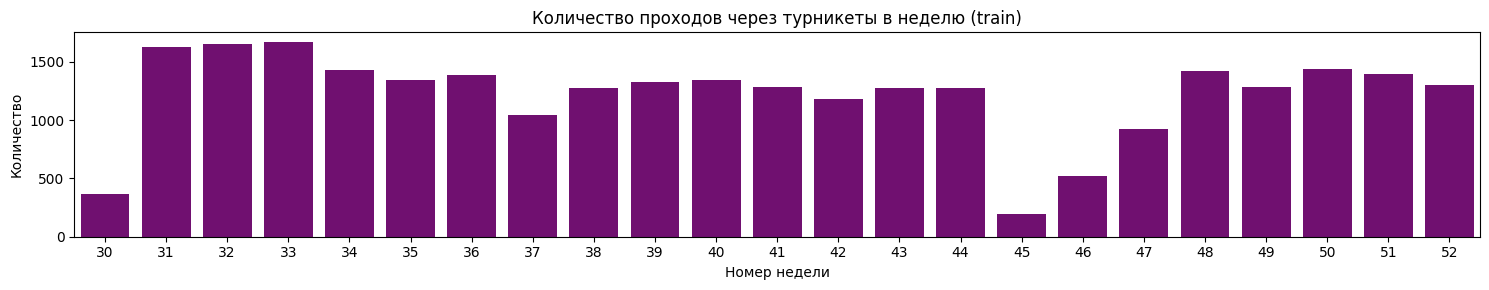

In [49]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [50]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [51]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

Мы видим, что 30 неделя - неполная, как и 45. Поскольку при генерировании признаков мы используем агрегацию по номеру недели, удалим данные за 30 и 45 недели из тренировочной выборки

In [52]:
df_train.shape

(27936, 68)

In [53]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(27378, 68)

In [54]:
df_train['user_id'].nunique()

31

Рассмотрим тестовую выборку

In [55]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

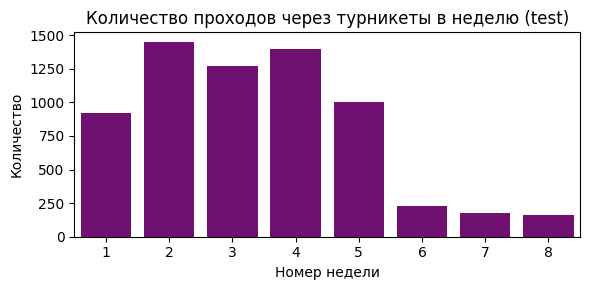

In [56]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [57]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [58]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [59]:
df_test.shape

(6612, 68)

In [60]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(6040, 68)

In [61]:
df_test['user_id'].nunique()

34

In [62]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

# удалим вспомогательные признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

## 5.3 Phik корреляция признаков с целевым признаком


In [63]:
%%time
phik_overview = df_train.phik_matrix()['user_id'].sort_values(ascending=False).to_frame()

interval columns not set, guessing: ['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes', 'total_seconds', 'day_of_week', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'entrance_gate_id', 'exit_gate_id', 'working_time_per_week', 'daily_workload_index', 'gate_id_lag_1', 'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1', 'gate_id_lag_2', 'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3', 'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4', 'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s', 'cnt_repeat_gate_3s', 'cnt_repeat_gate_4s', 'cnt_repeat_gate_ge_5s', 'cumtime_per_day', 'cumtime_at_route_per_day', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'weekly_route_avg_time', 'route_avg_time']
CPU times: total: 5.17 

In [64]:
phik_overview.style.background_gradient(cmap='Purples', vmin=0, vmax=1).format('{:.2f}')

,user_id
user_id,1.00
most_frequent_route_per_week,0.73
working_time_per_week,0.73
most_frequent_route_per_day,0.71
entry_time,0.61
daily_workload_index,0.59
entrance_gate_id,0.57
pass_cnt_per_day,0.57
most_frequent_gate_per_week,0.57
working_time_per_day,0.56


# 6 Построение моделей


## 6.1 Подготовка данных


In [65]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [66]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21902, 62), (5476, 62), (21902,), (5476,))

In [68]:
y_train.nunique(), y_test.nunique()

(31, 31)

In [69]:
X.columns

Index(['gate_id', 'day_of_month', 'hour', 'total_minutes', 'total_seconds',
       'day_of_week', 'is_weekend', 'time_of_day', 'is_month_start',
       'is_month_end', 'pass_cnt_per_day', 'daily_gate_pass_count',
       'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week',
       'daily_attendance_index', 'cnt_days_per_week', 'entry_time',
       'working_time_per_day', 'entrance_gate_id', 'exit_gate_id',
       'working_time_per_week', 'daily_workload_index', 'gate_id_lag_1',
       'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1', 'gate_id_lag_2', 'gate_id_2',
       'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3',
       'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4',
       'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5',
       'sec_btw_lag_5', 'sec_btw_5', 'repeat_gate_1s', 'repeat_gate_2s',
       'repeat_gate_3s', 'repeat_gate_4s', 'repeat_gate_ge_5s',
       'cnt_repeat_gate_1s', 'cnt_repeat_gate_2s', 'cnt_repeat_gate_3s',
       'cnt_rep

In [70]:
categorical_features = [
       'gate_id', 'day_of_month', 'hour',
       'day_of_week', 'is_weekend', 'time_of_day', 
       'is_month_start', 'is_month_end', 'entrance_gate_id', 
       'exit_gate_id', 'gate_id_lag_1', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s',
       'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]

## 6.2 Подбор гиперпараметров


Будем работать с `CatBoostClassifier`.

Оптимизация гиперпараметров проводилась с помощью фреймворка `Optuna`.

В качестве валидационной метрики, используемой для обнаружения переобучения и ранней остановки, выступала F1-мера с параметром `average='macro'`. В таком случае вычисляется F1-мера для каждого класса отдельно, затем полученные значения усредняются.

Использовали `StratifiedKFold` валидацию.

```python
def fit_catboost(trial, train, val, cat_features):
    X_train, y_train = train
    X_val, y_val = val
    # параметры для перебора
    param = {
        'n_estimators' : 2000, # можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred
```

```python
def objective(trial, X, y, cat_features, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features) # определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='macro'))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
```

```python
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X, y, categorical_features),
                n_trials=3,
                show_progress_bar=True,
)
```

```python
print(f'Best trial: score {study.best_trial.value}, params {study.best_trial.params}')

Best trial: score 0.9966736309138803, params {'learning_rate': 0.04031923286563071, 'l2_leaf_reg': 27.23443154592482, 'auto_class_weights': 'Balanced', 'max_depth': 8, 'border_count': 73}
```

```python
%%time

# обучение итоговых моделей на подобранных гиперпараметрах
valid_scores, models_all_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X, 
    y, 
    categorical_features,
    return_models=True,
)
```

```python

# среднее значение f1_score на кросс-валидации
print(valid_scores)
# количество деревьев
for m in models_all_features:
    print(m.tree_count_)

0.9966736309138803
1872
1281
1752
```

Подобранные гиперпараметры использовались в дальнейшем при отборе признаков.

## 6.3 Отбор признаков


Отбор признаков проводился с помощью метода у CatBoost - `.select_features()`. Это метод-обертка, который рекурсивно удаляет признаки на основе оценки важности для каждого признака. Использовали самый точный алгоритм рекурсивного удаления признаков - `RecursiveByShapValues`.

В качестве гиперпараметров `CatBoostClassifier` использовали найденные на предыдущем этапе.

В результате отобрали 18 признаков:

    'most_frequent_route_per_week',
    'working_time_per_week',
    'entry_time',
    'cnt_users_per_day',
    'cnt_repeat_gate_3s',
    'most_frequent_route_per_day',
    'route_avg_time',
    'daily_attendance_index',
    'cnt_repeat_gate_2s',
    'exit_gate_id',
    'daily_workload_index',
    'cnt_repeat_gate_1s',
    'entrance_gate_id',
    'working_time_per_day',
    'pass_cnt_per_day',
    'cnt_users_per_week',
    'cnt_days_per_week',
    'most_frequent_gate_per_week'

Ниже представлен код, с помощью которого происходил отбор признаков.

```python
# создаем список имен признаков
feature_names = list(X_train.columns)

# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=categorical_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=categorical_features)
```

```python
# пишем функцию отбора признаков на основе рекурсивного удаления признаков
def catboost_select_features(algorithm, steps=1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    **study.best_params,
                    n_estimators=1700,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    eval_metric='TotalF1:average=Macro',
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=3,
        # количество итераций обучения модели, вычисляющей оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary
```

```python
%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)
```

График изменения функции потерь по мере удалени признаков.

![](..\pictures\select_features.png)

На основе графика `Loss by eliminated features`, отберем из списка `eliminated_feat` фичи, начиная с 44-го индекса.

```python
# отобранные признаки
selected_feat = shap_summary['selected_features_names']
# исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']

selected_features = selected_feat + eliminated_feat[44:]
```

In [71]:
selected_features = [
    'most_frequent_route_per_week',
    'working_time_per_week',
    'entry_time',
    'cnt_users_per_day',
    'cnt_repeat_gate_3s',
    'most_frequent_route_per_day',
    'route_avg_time',
    'daily_attendance_index',
    'cnt_repeat_gate_2s',
    'exit_gate_id',
    'daily_workload_index',
    'cnt_repeat_gate_1s',
    'entrance_gate_id',
    'working_time_per_day',
    'pass_cnt_per_day',
    'cnt_users_per_week',
    'cnt_days_per_week',
    'most_frequent_gate_per_week'
]

In [72]:
len(selected_features)

18

In [73]:
cat_features = [
    'most_frequent_route_per_week',
    'most_frequent_route_per_day',
    'exit_gate_id',
    'entrance_gate_id',
    'most_frequent_gate_per_week'
]

## 6.4 Подбор гиперпараметров после отбора признаков


```python
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=5,
                show_progress_bar=True,
)
```

```python
print(f'Best trial: score {study.best_trial.value}, params {study.best_trial.params}')

Best trial: score 0.9986881999044241, params {'learning_rate': 0.04325415489908707, 'l2_leaf_reg': 18.338330868742815, 'auto_class_weights': 'Balanced', 'max_depth': 10, 'border_count': 84}
```

In [74]:
best_params = {
    'n_estimators' : 2000,
    'learning_rate': 0.04325415489908707, 
    'l2_leaf_reg': 18.338330868742815, 
    'auto_class_weights': 'Balanced', 
    'max_depth': 10, 
    'border_count': 84
}

X_new = X[selected_features]

In [75]:
%%time

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

scores, models = [], []

for train_idx, valid_idx in skf.split(X_new, y):
    X_train, y_train = X_new.iloc[train_idx, :], y.iloc[train_idx]
    X_val, y_val = X_new.iloc[valid_idx, :], y.iloc[valid_idx]

    clf = CatBoostClassifier(
        **best_params,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)

    scores.append(f1_score(y_val, y_pred, average='macro'))
    models.append(clf)

result = np.mean(scores)

0:	learn: 0.5120311	test: 0.4962075	best: 0.4962075 (0)	total: 288ms	remaining: 9m 35s
100:	learn: 0.9318659	test: 0.9249244	best: 0.9249244 (100)	total: 25.9s	remaining: 8m 7s
200:	learn: 0.9901533	test: 0.9874677	best: 0.9874677 (196)	total: 48.9s	remaining: 7m 18s
300:	learn: 0.9959134	test: 0.9938779	best: 0.9938779 (285)	total: 1m 11s	remaining: 6m 42s
400:	learn: 0.9980723	test: 0.9966054	best: 0.9966054 (394)	total: 1m 31s	remaining: 6m 5s
500:	learn: 0.9988756	test: 0.9980029	best: 0.9980029 (483)	total: 1m 51s	remaining: 5m 34s
600:	learn: 0.9994448	test: 0.9991288	best: 0.9991288 (598)	total: 2m 12s	remaining: 5m 7s
700:	learn: 0.9997169	test: 0.9997318	best: 0.9997318 (686)	total: 2m 32s	remaining: 4m 42s
bestTest = 0.9997318185
bestIteration = 686
Shrink model to first 687 iterations.
0:	learn: 0.5169725	test: 0.5048728	best: 0.5048728 (0)	total: 286ms	remaining: 9m 31s
100:	learn: 0.9524290	test: 0.9427776	best: 0.9427776 (100)	total: 25.1s	remaining: 7m 51s
200:	learn: 0.

In [76]:
print(f'Среднее значение F1-меры на кросс-валидации: {result:.3f}')

Среднее значение F1-меры на кросс-валидации: 0.999


In [77]:
# количество деревьев
for m in models:
    print(m.tree_count_)

687
539
879


## 6.5 Итоговое предсказание лучшей модели


In [78]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [79]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Сделаем предсказание

In [80]:
result_cb = make_prediction(df_test, selected_features, models)
result_cb

,user_word,preds
5,aucroc,24
1,binary,12
9,blue,56
2,categorical,14
33,coefficient,-999
18,collinear,22
17,distributed,0
0,epsilon,1
6,f1,6
21,fit,2


In [81]:
len(result_cb)

34

Сохраним результаты

In [82]:
csv_buffer = io.StringIO()

result_cb.to_csv(csv_buffer, index=False)

with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())